<a href="https://colab.research.google.com/github/DimOriCoding/Artificial-Intelligence-II/blob/main/Music_Genre_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#loading the datasets
from google.colab import drive

drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
  #training set
mfcc_x_train = np.load("mfcc_train_X.npy")
mfcc_labels_train = np.load("mfcc_train_labels.npy")

  #validation set
mfcc_x_val = np.load("mfcc_valid_X.npy")
mfcc_labels_val = np.load("mfcc_valid_labels.npy")

  #mfcc-test set
mfcc_x_test = np.load("mfcc_test_X.npy")
mfcc_labels_test = np.load("mfcc_test_labels.npy")

print("x_train:", mfcc_x_train.shape)
print("y_train:", mfcc_labels_train.shape)
print("x_val", mfcc_x_val.shape)
print("y_val", mfcc_labels_val.shape)
print("x_test", mfcc_x_test.shape)
print("y_test", mfcc_labels_test.shape)

x_train: (3200, 26)
y_train: (3200,)
x_val (800, 26)
y_val (800,)
x_test (1376, 26)
y_test (1376,)


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)


Device available for running: 
cpu


In [ ]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch
import torch.backends.cudnn
import torch.cuda


NameError: ignored

In [ ]:
#As suggested by PyTorch documentation, in multi-process data loading algorithm DataLoader
#will reseed the workers using worker_init_fn() in order to preserve reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader,Dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
mfcc_train_labels_encoded = label_encoder.fit_transform(mfcc_labels_train)
mfcc_valid_labels_encoded = label_encoder.fit_transform(mfcc_labels_val)
mfcc_test_labels_encoded = label_encoder.fit_transform(mfcc_labels_test)

print("y_train_encoded sample: ", mfcc_test_labels_encoded)
print("\nlabel mapping: ", label_encoder.classes_)
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nlabel map: ", label_map)

y_train_encoded sample:  [0 0 0 ... 3 3 3]

label mapping:  ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']

label map:  {0: 'blues', 1: 'classical', 2: 'hiphop', 3: 'rock_metal_hardrock'}


In [ ]:
#Creation of Datasets and Dataloaders for train validation and test datasets of mfcc
from torch.utils.data import TensorDataset,DataLoader,Dataset
training_data_mfcc = TensorDataset(torch.from_numpy(mfcc_x_train), torch.from_numpy(mfcc_train_labels_encoded))
validation_data_mfcc = TensorDataset(torch.from_numpy(mfcc_x_val), torch.from_numpy(mfcc_valid_labels_encoded))
test_data_mfcc =TensorDataset(torch.from_numpy(np.asarray(mfcc_x_test)), torch.from_numpy(mfcc_test_labels_encoded))
train_dataloader_mfcc = DataLoader(training_data_mfcc, batch_size=16, shuffle=True,  num_workers=0,
    worker_init_fn=seed_worker,
    generator=g)
validation_dataloader_mfcc = DataLoader(validation_data_mfcc, batch_size=16, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=g)
test_dataloader_mfcc = DataLoader(test_data_mfcc, batch_size=16, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=g)

In [ ]:
import torch.nn as nn
class FNN(nn.Module):
  def __init__(self, D_in: int, hiddenSizes: list, D_out: int):
    super(FNN, self).__init__()
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.dense1 = nn.Linear(D_in, hiddenSizes[0])
    self.dense2 = nn.Linear(hiddenSizes[0], hiddenSizes[1])
    self.dense3 = nn.Linear(hiddenSizes[1], hiddenSizes[0])
    self.dense4 = nn.Linear(hiddenSizes[0], D_out)

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
        module.bias.data.zero_()

  def forward(self, x):
      x = self.dense1(x)

      x = self.dense2(x)

      x = self.dense3(x)

      x = self.dense4(x)
      return x

In [ ]:
from torch.optim import Adam,SGD,Adagrad,RMSprop

#Define Hyperparameters
learning_rate = 0.002

#Initialise model, loss, optimizer
model = FNN(mfcc_x_train.shape[1], [128,32], 4).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
target_dtype = torch.float64
for param in model.parameters():
  param.data = param.data.to(target_dtype)
optimizer = SGD(model.parameters(), lr=learning_rate)

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dense1): Linear(in_features=26, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
def validation_function(dataloader,model,epoch,epochs,model_save_path, epoch_best_model, best_model, final_model, max_f1):
  model.eval()
  with torch.no_grad():
    batch_losses_val = []
    Y_batches = []
    Y_preds = []
    F1 = []
    accuracy = []
    for x,y in dataloader:
     x = x.to(device)
     y = y.to(device)
     y_pred = model(x)
     print(y_pred)
     predictions = nn.functional.softmax(y_pred, dim=1) #softmax outputs an array of probabilities per label that sum to 1.0
     y_pred = y_pred.argmax(1)
     val_loss = loss_func(y_pred.float(), y.float())
     batch_losses_val.append(val_loss)
     y_pr = y_pred.tolist()
     y_val = y.tolist()
     Y_batches.append(y)
     Y_preds.append(y_pred)
     f1 = f1_score(y_val, y_pr, average='macro')
     F1.append(f1)
     accuracy.append(accuracy_score(y_val,y_pr))
    Y_batches = torch.cat(Y_batches)
    Y_preds = torch.cat(Y_preds)
    Valid_loss = sum(batch_losses_val)/len(dataloader)
    Valid_f1 = sum(F1)/len(dataloader)
    Valid_accuracy = sum(accuracy)/len(dataloader)
    if Valid_f1 > max_f1:
      max_f1 = Valid_f1
      print(max_f1)
      best_model = model
      torch.save(best_model.state_dict(), model_save_path)
      epoch_best_model = epoch
    final_model = best_model
    print(f"\n The Best model is saved on epoch: {epoch_best_model}")
    print(f"\n The best model is saved under path: {model_save_path}")
    if epoch!= 0 and epoch % (epochs-1) == 0:
     cm = confusion_matrix(np.asarray(Y_batches), np.asarray(Y_preds))
     cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
     cm_disp.plot()
     plt.show()

  return Valid_loss,Valid_f1,Valid_accuracy, confusion_matrix, epoch_best_model, best_model,final_model, max_f1

In [ ]:
import time
import os
#y_pred.argmax(1).float()
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def train_function(epochs, optimizer, dataloader, loss_func, model, saved_dir, saved_model_name, validation_dataloader):
 start = time.time()
 if not os.path.exists(saved_dir):
   os.makedirs(saved_dir)
 model_save_path = os.path.join(saved_dir, saved_model_name)
 best_model, final_model = None,None
 epoch_best_model = 0
 max_f1 = -1
 for epoch in range(epochs):
   model.train()
   batch_losses = []
   for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    loss = loss_func(y_pred.argmax(1).float().requires_grad_(True), y_batch.float().requires_grad_(True))
    batch_losses.append(loss.item())
    #Delete previously stored gradients
    optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
   print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(dataloader):.5f}")
   batch_losses_val = []
   Y_batches = []
   Y_preds = []
   F1 = []
   accuracy = []
   with torch.no_grad():
    model.eval()
    for x,y in validation_dataloader:
     x = x.to(device)
     y = y.to(device)
     y_pred = model(x)
     y_pred = nn.functional.softmax(y_pred, dim=1) #softmax outputs an array of probabilities per label that sum to 1.0
     y_pred = np.argmax(y_pred, axis = 1)
     val_loss = loss_func(y_pred.float(), y.float())
     batch_losses_val.append(val_loss)
     y_pr = y_pred.tolist()
     y_val = y.tolist()
     Y_batches.append(y)
     Y_preds.append(y_pred)
     f1 = f1_score(y_val, y_pr, average='macro')
     F1.append(f1)
     accuracy.append(accuracy_score(y_val,y_pr))
    Y_batches = torch.cat(Y_batches)
    Y_preds = torch.cat(Y_preds)
    Valid_loss = sum(batch_losses_val)/len(validation_dataloader)
    Valid_f1 = sum(F1)/len(validation_dataloader)
    Valid_accuracy = sum(accuracy)/len(validation_dataloader)
    if Valid_f1 > max_f1:
      max_f1 = Valid_f1
      print(max_f1)
      best_model = model
      torch.save(best_model.state_dict(), model_save_path)
      epoch_best_model = epoch
    final_model = best_model
    print(f"\n The Best model is saved on epoch: {epoch_best_model}")
    print(f"\n The best model is saved under path: {model_save_path}")
    if epoch!= 0 and epoch % (epochs-1) == 0:
     cm = confusion_matrix(np.asarray(Y_batches), np.asarray(Y_preds))
     cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
     cm_disp.plot()
     plt.show()

   print(f"Epoch {epoch:3}: Valid Loss = {Valid_loss:.5f}")
   print(f"Epoch {epoch:3}: Valid f1_score = {Valid_f1:.5f}")
   print(f"Epoch {epoch:3}: Valid Acurracy = {Valid_accuracy:.5f}")
 end = time.time()
 print("done in % 0.3fs" % (end - start))
 return final_model


Epoch   0: Train Loss = 66.54213
0.09837438632619676

 The Best model is saved on epoch: 0

 The best model is saved under path: gdrive/MyDrive/data/FNN_Model_best
Epoch   0: Valid Loss = 66.54214
Epoch   0: Valid f1_score = 0.09837
Epoch   0: Valid Acurracy = 0.25000
Epoch   1: Train Loss = 66.54213

 The Best model is saved on epoch: 0

 The best model is saved under path: gdrive/MyDrive/data/FNN_Model_best
Epoch   1: Valid Loss = 66.54214
Epoch   1: Valid f1_score = 0.09704
Epoch   1: Valid Acurracy = 0.25000
Epoch   2: Train Loss = 66.54213

 The Best model is saved on epoch: 0

 The best model is saved under path: gdrive/MyDrive/data/FNN_Model_best
Epoch   2: Valid Loss = 66.54211
Epoch   2: Valid f1_score = 0.09777
Epoch   2: Valid Acurracy = 0.25000
Epoch   3: Train Loss = 66.54213
0.09979668834179528

 The Best model is saved on epoch: 3

 The best model is saved under path: gdrive/MyDrive/data/FNN_Model_best
Epoch   3: Valid Loss = 66.54214
Epoch   3: Valid f1_score = 0.09980


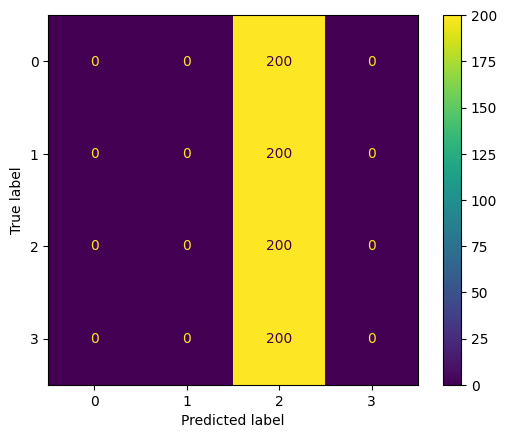

Epoch  29: Valid Loss = 66.54213
Epoch  29: Valid f1_score = 0.09804
Epoch  29: Valid Acurracy = 0.25000
done in  8.994s
FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dense1): Linear(in_features=26, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
final_model = train_function(30,optimizer,train_dataloader_mfcc,loss_func,model, "gdrive/MyDrive/data/", "FNN_Model_best",validation_dataloader_mfcc)
print(final_model)

**Ο χρόνος εκτέλεσης σε CPU είναι tCPU = 12.566 seconds και ο αντίστοιχος χρόνος σε GPU είναι tGPU = 12.196 seconds, άρα η διαφορά τους Δt = |tCPU-tGPU| = 2.259 seconds.**

In [ ]:
#Evaluation of the test set by using the best model that occured from validation set

final_model.eval()
print(validation_function(test_dataloader_mfcc,model,1,2,"gdrive/MyDrive/data/FNN_Model_best", 24, model, final_model, -1))


NameError: ignored

In [ ]:
#loading the datasets for melgrams
import numpy as np
  #training set
mel_x_train = np.load("melgram_train_X.npy")
mel_labels_train = np.load("melgram_train_labels.npy")

  #validation set
mel_x_val = np.load("melgram_valid_X.npy")
mel_labels_val = np.load("melgram_valid_labels.npy")

  #test set
mel_x_test = np.load("melgram_test_X.npy")
mel_labels_test = np.load("melgram_test_labels.npy")

print("x_train:", mel_x_train.shape)
print("y_train:", mel_labels_train.shape)
print("x_val", mel_x_val.shape)
print("y_val", mel_labels_val.shape)
print("x_test", mel_x_test.shape)
print("y_test", mel_labels_test.shape)


x_train: (3200, 21, 128)
y_train: (3200,)
x_val (800, 21, 128)
y_val (800,)
x_test (1376, 21, 128)
y_test (1376,)


In [ ]:
label_encoder = LabelEncoder()
mel_train_labels_encoded = label_encoder.fit_transform(mel_labels_train)
mel_val_labels_encoded = label_encoder.fit_transform(mel_labels_val)
mel_test_labels_encoded = label_encoder.fit_transform(mel_labels_test)
print("y_train_encoded sample: ", mel_train_labels_encoded)
print("\nlabel mapping: ", label_encoder.classes_)
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nlabel map: ", label_map)


y_train_encoded sample:  [0 0 0 ... 3 3 3]

label mapping:  ['blues' 'classical' 'hiphop' 'rock_metal_hardrock']

label map:  {0: 'blues', 1: 'classical', 2: 'hiphop', 3: 'rock_metal_hardrock'}


In [ ]:
#mel_train = torch.tensor(np.asarray(mel_train), dtype=torch.float, device=device)
#mel_train_labels_encoded = mel_train_labels_encoded.float()
#mel_valid = torch.tensor(np.asarray(mel_valid), dtype=torch.float, device=device)
#mel_val_labels_encoded = mel_val_labels_encoded.float()
#mel_test = torch.tensor(np.asarray(mel_test), dtype=torch.float, device=device)
#mel_test_labels_encoded = mel_test_labels_encoded.float()
training_data_mel = TensorDataset(torch.from_numpy(mel_x_train), torch.from_numpy(mel_train_labels_encoded))
validation_data_mel = TensorDataset(torch.from_numpy(mel_x_val), torch.from_numpy(mel_val_labels_encoded))
test_data_mel =TensorDataset(torch.from_numpy(mel_x_test), torch.from_numpy(mel_test_labels_encoded))
train_dataloader_mel = DataLoader(training_data_mel, batch_size=16, shuffle=True,num_workers=0, worker_init_fn=seed_worker,generator=g)
validation_dataloader_mel = DataLoader(validation_data_mel, batch_size=16, shuffle=True,num_workers=0, worker_init_fn=seed_worker,generator=g)
test_dataloader_mel = DataLoader(test_data_mel, batch_size=16, shuffle=True, num_workers=0, worker_init_fn=seed_worker,generator=g)


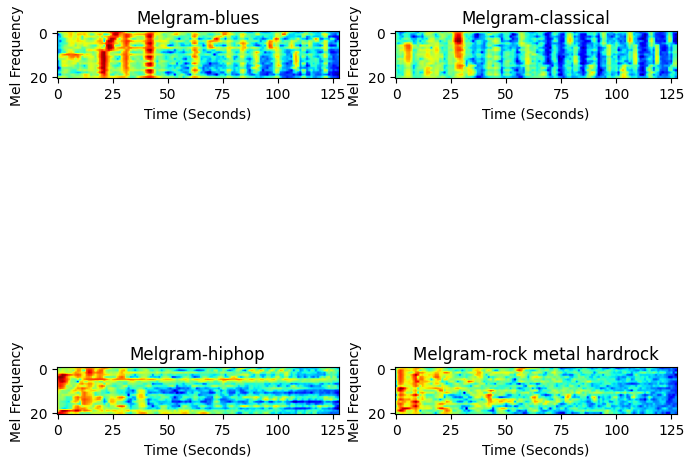

In [ ]:
import random
import matplotlib.pyplot as plt
#Count how much labels there are from each music category in training validation and test data for our convenience in plotting the music classes.
def count_labels(dataset_mel):
 c0 = 0
 c1 = 0
 c2 = 0
 c3 = 0
 for k in range(len(dataset_mel)):
   if dataset_mel[k][1] == torch.tensor(0.):
      c0 += 1
   elif dataset_mel[k][1] == torch.tensor(1.):
      c1 += 1
   elif dataset_mel[k][1] == torch.tensor(2.):
      c2 += 1
   else:
      c3 += 1
 return c0,c1,c2,c3
train_0,train_1,train_2,train_3 = count_labels(training_data_mel)
val_0,val_1,val_2,val_3 = count_labels(validation_data_mel)
test_0,test_1,test_2,test_3 = count_labels(test_data_mel)

def plot_music_classes(c0,c1,c2,c3,data_mel):
 sample_idx = []
 plt.subplots(2,2,figsize = (8,8))
 sample_idx_blues = torch.randint(1,c0, size=(1,)).item()
 sample_idx_classical = torch.randint((c0),(c0+c1), size=(1,)).item()
 sample_idx_hiphop = torch.randint((c0+c1),(c0+c1+c2), size=(1,)).item()
 sample_idx_rockmetal = torch.randint((c0+c1+c2),(c0+c1+c2+c3), size=(1,)).item()
 sample_idx.append(sample_idx_blues)
 sample_idx.append(sample_idx_classical)
 sample_idx.append(sample_idx_hiphop)
 sample_idx.append(sample_idx_rockmetal)
 rows, columns = 2,2
 for i in range(1, rows*columns+1):
  img, label = data_mel[sample_idx[i-1]]
  plt.subplot(rows, columns, i)
  plt.imshow(img.squeeze(), cmap="jet")
  if label == torch.tensor(0.):
      plt.title('Melgram-blues')
  elif label == torch.tensor(1.):
      plt.title('Melgram-classical')
  elif label == torch.tensor(2.):
      plt.title('Melgram-hiphop')
  else:
      plt.title('Melgram-rock metal hardrock')

  plt.xlabel("Time (Seconds)")
  plt.ylabel("Mel Frequency")
 plt.show()
plot_music_classes(train_0,train_1,train_2,train_3,training_data_mel)


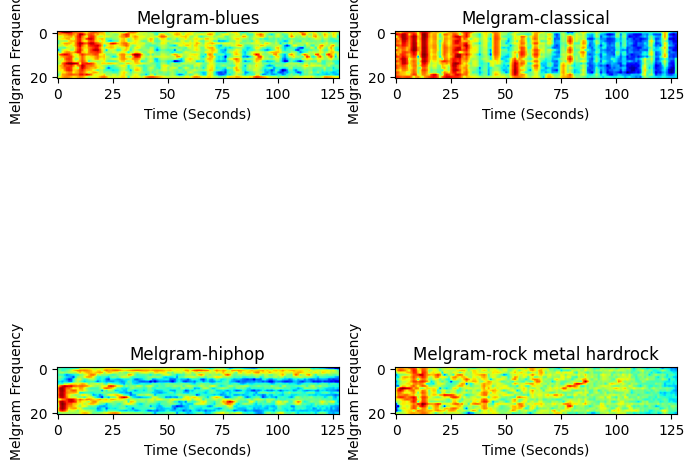

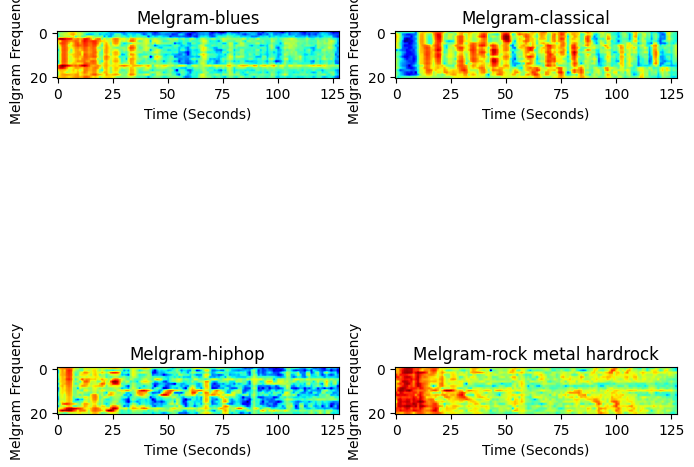

In [ ]:
plot_music_classes(val_0,val_1,val_2,val_3,validation_data_mel)
plot_music_classes(test_0,test_1,test_2,test_3,test_data_mel)

In [ ]:
#Build convolutional network for the melgrams dataset with max pooling in the convolutional layers
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,SGD,Adagrad,Adadelta
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
class ConvolutionalNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)
    self.conv2 = nn.Conv2d(16, 32, 5 , padding = 2)
    self.conv3 = nn.Conv2d(32, 64, 5 , padding = 2)
    self.conv4 = nn.Conv2d(64, 128, 5 , padding = 2)
    self.flat = nn.Flatten()
    self.max_pool = nn.AdaptiveMaxPool2d(output_size = 1)
    self.activation = nn.ReLU()
    self.dense1 = nn.Linear(128, 1024)
    self.dense2 = nn.Linear(1024, 256)
    #self.dense3 = nn.Linear(256, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
        module.bias.data.zero_()

  def forward(self, x):
      x = x.unsqueeze(1)
      #print(x.shape)
      x = self.conv1(x)
      x = self.activation(x)
      x = self.max_pool(x)
      x = self.conv2(x)
      x = self.activation(x)
      x = self.max_pool(x)
      x = self.conv3(x)
      x = self.activation(x)
      x = self.max_pool(x)
      x = self.conv4(x)
      x = self.activation(x)
      x = self.max_pool(x)
      x = x.view(x.size(0),-1)
      #print(x.shape)

      x = self.dense1(x)
      x = self.activation(x)
      x = self.dense2(x)
      x = self.activation(x)
      x = self.dense3(x)
      #x = self.relu(self.dense4(x))
      #x = self.activation(self.dense4(x))
      #print(x)
      x = self.activation(x)
      x = self.dense4(x)


      return x

model_conv = ConvolutionalNet().to(device)

# define the corresponding loss function and the optimizer
#loss_fn = nn.CrossEntropyLoss()
opt = Adam(model_conv.parameters(), lr = 0.002)
scheduler1 = ExponentialLR(opt, gamma=0.9, verbose =  True)
scheduler2 = MultiStepLR(opt, milestones=[20,30], gamma=0.1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.


In [ ]:
def train_function_with_lr_scheduler(epochs, optimizer, dataloader, scheduler, loss_func, model, saved_dir, saved_model_name, validation_dataloader):
 start = time.time()
 if not os.path.exists(saved_dir):
   os.makedirs(saved_dir)
 model_save_path = os.path.join(saved_dir, saved_model_name)
 best_model, final_model = None,None
 epoch_best_model = 0
 max_f1 = -1
 model.train()
 for epoch in range(epochs):

   batch_losses = []
   for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    loss = loss_func(y_pred.argmax(1).float().requires_grad_(True), y_batch.float().requires_grad_(True))
    batch_losses.append(loss.item())
    #Delete previously stored gradients
    optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    scheduler.step()
   print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(dataloader):.5f}")
   batch_losses_val = []
   Y_batches = []
   Y_preds = []
   F1 = []
   accuracy = []
   with torch.no_grad():
    model.eval()
    for x,y in validation_dataloader:
     x = x.to(device)
     y = y.to(device)
     y_pred = model(x)

     y_pred = np.argmax(y_pred, axis = 1)
     val_loss = loss_func(y_pred.float(), y.float())
     batch_losses_val.append(val_loss)
     y_pr = y_pred.tolist()
     y_val = y.tolist()
     Y_batches.append(y)
     Y_preds.append(y_pred)
     f1 = f1_score(y_val, y_pr, average='macro')
     F1.append(f1)
     accuracy.append(accuracy_score(y_val,y_pr))
    Y_batches = torch.cat(Y_batches)
    Y_preds = torch.cat(Y_preds)
    Valid_loss = sum(batch_losses_val)/len(validation_dataloader)
    Valid_f1 = sum(F1)/len(validation_dataloader)
    Valid_accuracy = sum(accuracy)/len(validation_dataloader)
    if Valid_f1 > max_f1:
      max_f1 = Valid_f1
      print(max_f1)
      best_model = model
      torch.save(best_model.state_dict(), model_save_path)
      epoch_best_model = epoch
    final_model = best_model
    print(f"\n The Best model is saved on epoch: {epoch_best_model}")
    print(f"\n The best model is saved under path: {model_save_path}")
    if epoch!= 0 and epoch % (epochs-1) == 0:
     cm = confusion_matrix(np.asarray(Y_batches), np.asarray(Y_preds))
     cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
     cm_disp.plot()
     plt.show()

   print(f"Epoch {epoch:3}: Valid Loss = {Valid_loss:.5f}")
   print(f"Epoch {epoch:3}: Valid f1_score = {Valid_f1:.5f}")
   print(f"Epoch {epoch:3}: Valid Acurracy = {Valid_accuracy:.5f}")
 end = time.time()
 print("done in % 0.3fs" % (end - start))
 return final_model

Epoch   0: Train Loss = 66.54213
0.09675069367598643

 The Best model is saved on epoch: 0

 The best model is saved under path: gdrive/MyDrive/data/Convolutional_Model_best
Epoch   0: Valid Loss = 66.54214
Epoch   0: Valid f1_score = 0.09675
Epoch   0: Valid Acurracy = 0.25000
Epoch   1: Train Loss = 66.54213
0.09857324975618147

 The Best model is saved on epoch: 1

 The best model is saved under path: gdrive/MyDrive/data/Convolutional_Model_best
Epoch   1: Valid Loss = 66.54214
Epoch   1: Valid f1_score = 0.09857
Epoch   1: Valid Acurracy = 0.25000
Epoch   2: Train Loss = 66.54213

 The Best model is saved on epoch: 1

 The best model is saved under path: gdrive/MyDrive/data/Convolutional_Model_best
Epoch   2: Valid Loss = 66.54212
Epoch   2: Valid f1_score = 0.09811
Epoch   2: Valid Acurracy = 0.25000
Epoch   3: Train Loss = 66.54213

 The Best model is saved on epoch: 1

 The best model is saved under path: gdrive/MyDrive/data/Convolutional_Model_best
Epoch   3: Valid Loss = 66.54

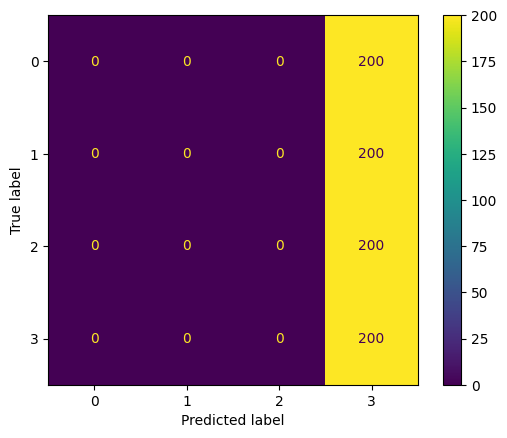

Epoch  29: Valid Loss = 66.54213
Epoch  29: Valid f1_score = 0.09855
Epoch  29: Valid Acurracy = 0.25000
done in  74.855s
ConvolutionalNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (max_pool): AdaptiveMaxPool2d(output_size=1)
  (activation): ReLU()
  (dense1): Linear(in_features=128, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
final_model_conv = train_function(30,opt,train_dataloader_mel,loss_func,model_conv, "gdrive/MyDrive/data/", "Convolutional_Model_best",validation_dataloader_mel)
print(final_model_conv)

In [ ]:
#mapping the labels to integers
def mapping_labels(a):
  if a == 'blues':
     return 0
  elif a == 'classical':
    return 1
  elif a == 'hiphop':
    return 2
  else:
    return 3
#mapping the labels to integers for melgrams
mel_train_labels = list(map(mapping_labels,mel_train_labels))
print(len(mel_train_labels), mel_train_labels)
mel_valid_labels = list(map(mapping_labels,mel_validation_labels))
print(len(mel_valid_labels), mel_valid_labels)
mel_test_labels = list(map(mapping_labels,mel_test_labels))
print(len(mel_test_labels), mel_test_labels)

print(mfcc_train_labels)
mfcc_train_labels = list(map(mapping_labels,mfcc_train_labels))
print(len(mfcc_train_labels), mfcc_train_labels)
mfcc_valid_labels = list(map(mapping_labels,mfcc_validation_labels))
print(len(mfcc_valid_labels), mfcc_valid_labels)
mfcc_test_labels = list(map(mapping_labels,mfcc_test_labels))
print(len(mfcc_test_labels), mfcc_test_labels)